In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [109]:
image_size = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name).resize((128,128), Image.ANTIALIAS)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader('./scream.jpg')
content_img = image_loader('./face.jpeg')

assert style_img.size() == content_img.size(), "Style and Content images should be of the same size."

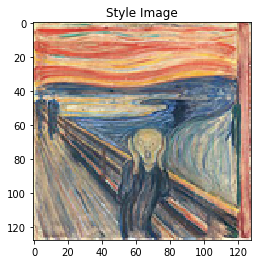

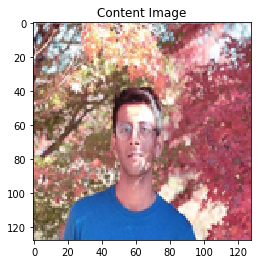

In [110]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
        
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [111]:
class ContentLoss(nn.Module):
    
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [112]:
def gram_matrix(input):
    a, b, c, d = input.size()
    
    features = input.view(a*b, c*d)
    
    G = torch.mm(features, features.t())
    
    return G.div(a*b*c*d)

In [113]:
class StyleLoss(nn.Module):
    
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [114]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [115]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [116]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img, content_layers=content_layers_default, style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []
    
    model = nn.Sequential(normalization)
    
    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            
        model.add_module(name, layer)
        
        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
            
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

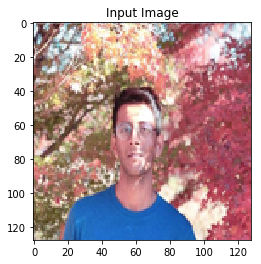

In [117]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

In [118]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [119]:
def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img, input_img, num_steps=300, style_weight=1000000, content_weight=1):
    print('Building the style transfer model...')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing...')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model...
Optimizing...
run [50]:
Style Loss : 114.363632 Content Loss: 36.881958

run [100]:
Style Loss : 36.354431 Content Loss: 37.099243

run [150]:
Style Loss : 19.909254 Content Loss: 35.379604

run [200]:
Style Loss : 13.507006 Content Loss: 33.495552

run [250]:
Style Loss : 10.599070 Content Loss: 31.915625

run [300]:
Style Loss : 8.916988 Content Loss: 30.724781



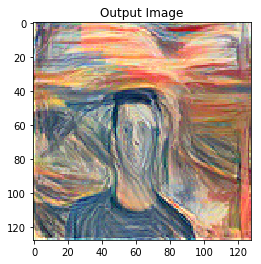

In [120]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()